<a href="https://colab.research.google.com/github/TuguduMiamMiam/Projet-piscine/blob/main/starters/ts-project-starter/ts-project/notebooks/lstm_jena_climate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regression Starter — Colab

> Author: Gouesse Sixtine & Gentieu Martin

Ce notebook est un projet de bout en bout pour de la **régression tabulaire** sur le dataset **Jena Climate** avec un **MLP PyTorch**.

# M1 — Problem Scoping & Data Validation

### Problem Statement
L’objectif de ce projet est d’entraîner un modèle **LSTM (Long Short-Term Memory)** pour **prédire la température future** à partir d’une série temporelle multivariée issue du dataset **Jena Climate**.

Le problème est un cas typique de régression de séries temporelles.

- **Entrée du modèle :** Une fenêtre temporelle de longueur fixe (seq_len = 48), contenant les observations multivariées des dernières 48 étapes (chaque pas = 10 minutes).
- **Sortie :** Une valeur réelle correspondant à la température prédite (en °C) au temps : t+horizon

## Model Inputs

Les features d’entrée (colonnes) :

- `T (degC)`
- `p (mbar)`
- `rho (g/m**3)`
- `wv (m/s) (wind velocity)`
- `wd (deg) (wind direction)`
- `max. wv (m/s)`
- `radiation (selon version du dataset)`

## Model Outputs

- Une **valeur réelle** : prédiction du `température`.

La prédiction est d’abord produite dans l’espace standardisé (z-score), puis convertie en degrés Celsius via inverse transform.

### Evaluation Metrics
- **MSE**
- **MAE**
- **R²**
- **plot of predictions vs ground truth**

Visualisations complémentaires :
- Résidus vs prédictions
- Histogramme des erreurs

## Data Card – Jena Climate Dataset

**Nom du dataset :** Jena Climate (2009–2016)

**Source :** Version Kaggle du dataset Jena Climate via mnassrib/jena-climate.
Données fournies par le Max Planck Institute for Biogeochemistry (Jena, Allemagne).

**Tâche :** Modélisation de séries temporelles multivariées, régression sur séquences.

**Format brut :**

- Fichier CSV unique `jena_climate_2009_2016.csv`,
- 420 551 lignes (~8 ans de mesures)
- Un enregistrement toutes les 10 minutes,
- Colonne temporelle : `"Date Time"`
- Plusieurs colonnes physiques : température, pression, vent, humidité, etc.

**Pré-processing appliqué dans ce notebook :**

- Tri par colonne temporelle
- Séparation en splits **train / val / test** : 70% / 15% / 15%,
- Standardisation (z-score) des features et cible fit sur le train uniquement
- Construction de séquences temporelles de taille seq_len = 48
- Construction de DataLoaders PyTorch pour LSTM.

**Impact & risques :**

- Les données proviennent d’un seul site géographique, modèle non généralisable à d’autres régions.
- Forte saisonnalité et cycles journaliers importants, risque de sur-apprentissage.
- Les capteurs physiques peuvent introduire :
> du bruit
>
> des biais instrumentaux
>
> des dérives dans le temps
- Un modèle uniquement basé sur données historiques peut être sensible aux changements climatiques ou aux anomalies non observées dans le passé.

## Ouverture du dataset et installation

### Connexion à github

Pour github : à exécuter dans le terminal de colab

git clone https://github.com/MGentieu/dl_project.git

### Step 0 — Confirm the GPU is ready
Run the next cell. You should see GPU name + memory. If you see `nvidia-smi unavailable`, switch the runtime to GPU and rerun this cell.

In [40]:
!nvidia-smi || echo "nvidia-smi unavailable (CPU runtime)"


Thu Dec  4 11:24:15 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   47C    P0             27W /   72W |     263MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### Step 1 — Point the notebook at the project folder
This cell switches into the `ts-project` directory.
If you get a `FileNotFoundError`, confirm where you uploaded/cloned the folder, adjust the path, and rerun.

In [41]:
import os
import sys
from pathlib import Path

# The user has provided the explicit path to the project root.
PROJECT_ROOT = Path("/content/dl_project/starters/ts-project-starter/ts-project")

print(f"Environment: Colab/Kaggle (remote server), using provided PROJECT_ROOT")

# Validate structure
if not (PROJECT_ROOT / "src").exists():
    raise FileNotFoundError(f"Missing src/ directory at {PROJECT_ROOT}")

# Setup Python path
os.chdir(PROJECT_ROOT)
src_path = str(PROJECT_ROOT / "src")
if src_path not in sys.path:
    sys.path.insert(0, src_path)

print(f"Project root: {PROJECT_ROOT}")
print(f"Working directory: {Path.cwd()}")

# Required paths inside the project
DATA_DIR = PROJECT_ROOT / "data"
OUTPUT_DIR = PROJECT_ROOT / "outputs"
CONFIG_DIR = PROJECT_ROOT / "configs"
NOTEBOOK_DIR = PROJECT_ROOT / "notebooks"

# Create dirs if missing
for d in [DATA_DIR, OUTPUT_DIR, CONFIG_DIR, NOTEBOOK_DIR]:
    d.mkdir(parents=True, exist_ok=True)

print("Project folders validated:")
print(f"  DATA_DIR    = {DATA_DIR}")
print(f"  OUTPUT_DIR  = {OUTPUT_DIR}")
print(f"  CONFIG_DIR  = {CONFIG_DIR}")
print(f"  NOTEBOOK_DIR= {NOTEBOOK_DIR}")


Environment: Colab/Kaggle (remote server), using provided PROJECT_ROOT
Project root: /content/dl_project/starters/ts-project-starter/ts-project
Working directory: /content/dl_project/starters/ts-project-starter/ts-project
Project folders validated:
  DATA_DIR    = /content/dl_project/starters/ts-project-starter/ts-project/data
  OUTPUT_DIR  = /content/dl_project/starters/ts-project-starter/ts-project/outputs
  CONFIG_DIR  = /content/dl_project/starters/ts-project-starter/ts-project/configs
  NOTEBOOK_DIR= /content/dl_project/starters/ts-project-starter/ts-project/notebooks


### Step 2 — Install the project requirements
Installs PyTorch + supporting libraries from `requirements.txt`. Expect quite a bit of output. If the install fails, rerun the cell before continuing.

In [3]:
!pip install torch
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install tqdm
!pip install pyyaml
!pip install kagglehub
!pip install scikit-learn


In [42]:
# Standard library
import os
import sys
from pathlib import Path
import json
import csv
import random

# Numerical / Data manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt

# Machine Learning (scikit-learn)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score
)

# Deep Learning framework
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Additional utilities
from tqdm import tqdm
import yaml
import kagglehub

print("Imports loaded successfully.")

Imports loaded successfully.


In [43]:
print("CUDA available:", torch.cuda.is_available())
print("CUDA device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")


CUDA available: True
CUDA device: NVIDIA L4


In [44]:
# ============================================================
# Reproducibility
# ============================================================

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

if torch.cuda.is_available():
    torch.cuda.manual_seed_all

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
print("Torch version:", torch.__version__)


Using device: cuda
Torch version: 2.9.0+cu126


### Step 3 - Download and view samples

On télécharge maintenant le dataset via **KaggleHub** et on inspecte sa structure.

In [45]:
print("Downloading Jena Climate dataset via KaggleHub...")
jena_kaggle_path = kagglehub.dataset_download("mnassrib/jena-climate")
jena_kaggle_path = Path(jena_kaggle_path)
print("Dataset Kaggle téléchargé dans :", jena_kaggle_path)

# Create dataset folder inside the project
JENA_DIR = DATA_DIR / "jena"
JENA_DIR.mkdir(parents=True, exist_ok=True)

# Copy CSV into project structure
raw_csv = jena_kaggle_path / "jena_climate_2009_2016.csv"
jena_csv_path = JENA_DIR / "jena_climate_2009_2016.csv"

jena_csv_path.write_bytes(raw_csv.read_bytes())
print("Fichier copié dans le projet :", jena_csv_path)


100%|██████████| 13.2M/13.2M [00:01<00:00, 7.94MB/s]

Extracting files...


Dataset Kaggle téléchargé dans : /root/.cache/kagglehub/datasets/mnassrib/jena-climate/versions/1
Fichier copié dans le projet : /content/dl_project/starters/ts-project-starter/ts-project/data/jena/jena_climate_2009_2016.csv


In [46]:
# Quick inspection
df = pd.read_csv(jena_csv_path)
print(df.head())
print(df.describe())

             Date Time  p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  rh (%)  \
0  01.01.2009 00:10:00    996.52     -8.02    265.40        -8.90    93.3   
1  01.01.2009 00:20:00    996.57     -8.41    265.01        -9.28    93.4   
2  01.01.2009 00:30:00    996.53     -8.51    264.91        -9.31    93.9   
3  01.01.2009 00:40:00    996.51     -8.31    265.12        -9.07    94.2   
4  01.01.2009 00:50:00    996.51     -8.27    265.15        -9.04    94.1   

   VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh (g/kg)  H2OC (mmol/mol)  \
0          3.33          3.11          0.22       1.94             3.12   
1          3.23          3.02          0.21       1.89             3.03   
2          3.21          3.01          0.20       1.88             3.02   
3          3.26          3.07          0.19       1.92             3.08   
4          3.27          3.08          0.19       1.92             3.09   

   rho (g/m**3)  wv (m/s)  max. wv (m/s)  wd (deg)  
0       1307.75      1.03        

### Step 4 -  Configuration YAML pour Jena

In [48]:
jena_cfg = {
    "task": "regression_timeseries",
    "seed": SEED,
    "output_dir": str(OUTPUT_DIR),
    "data": {
        "csv_path": str(jena_csv_path),
        "time_col": "Date Time",
        "target_col": "T (degC)",
        "feature_cols": None,   # toutes les colonnes numériques sauf target
        "seq_len": 48,
        "horizon": 1,
        "val_split": 0.2,
        "test_split": 0.1,
        "standardize": True,
    },
    "model": {
        "type": "lstm",
        "hidden_dim": 128,
        "num_layers": 1,
        "bidirectional": False,
        "dropout": 0.1,
    },
    "train": {
        "epochs": 40,
        "batch_size": 256,
        "lr": 1.0e-3,
        "weight_decay": 0.0,
        "optimizer": "adamw",
        "scheduler": "cosine",
        "t_max": 40,
    },
    "early_stopping": {
        "patience": 6,
        "min_delta": 0.0,
    },
}

YAML_JENA = CONFIG_DIR / "jena_lstm.yaml"
with open(YAML_JENA, "w") as f:
    yaml.dump(jena_cfg, f)

print("\n=== jena_lstm.yaml ===")
print(open(YAML_JENA).read())


=== jena_lstm.yaml ===
data:
  csv_path: /content/dl_project/starters/ts-project-starter/ts-project/data/jena/jena_climate_2009_2016.csv
  feature_cols: null
  horizon: 1
  seq_len: 48
  standardize: true
  target_col: T (degC)
  test_split: 0.1
  time_col: Date Time
  val_split: 0.2
early_stopping:
  min_delta: 0.0
  patience: 6
model:
  bidirectional: false
  dropout: 0.1
  hidden_dim: 128
  num_layers: 1
  type: lstm
output_dir: /content/dl_project/starters/ts-project-starter/ts-project/outputs
seed: 42
task: regression_timeseries
train:
  batch_size: 256
  epochs: 40
  lr: 0.001
  optimizer: adamw
  scheduler: cosine
  t_max: 40
  weight_decay: 0.0



On charge le config

In [50]:
with open(YAML_JENA, "r") as f:
    cfg = yaml.safe_load(f)

data_cfg = cfg["data"]
model_cfg = cfg["model"]
train_cfg = cfg["train"]
early_cfg = cfg["early_stopping"]

df = pd.read_csv(data_cfg["csv_path"])
df = df.sort_values(data_cfg["time_col"]).reset_index(drop=True)

### Step 5 - Build MLP Dataset (Train/Val/Test)

Le split sera :
- 70% train
- 15% val
- 15% test


Split Train / Val / Test

In [51]:
# ============================================================
# Robust Train / Val / Test Splits (70 / 15 / 15)
# ============================================================
time_col = data_cfg["time_col"]
target_col = data_cfg["target_col"]

# Colonnes numériques
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
feature_cols = [c for c in numeric_cols if c != target_col]

X_all = df[feature_cols].values.astype(np.float32)
y_all = df[[target_col]].values.astype(np.float32)

print("Feature columns :", feature_cols)
print("Target column   :", target_col)
print("X_all shape :", X_all.shape, "| y_all shape :", y_all.shape)

n_total = len(df)
test_size = int(n_total * data_cfg["test_split"])
val_size = int(n_total * data_cfg["val_split"])
train_size = n_total - val_size - test_size

X_train_raw = X_all[:train_size]
y_train_raw = y_all[:train_size]

X_val_raw = X_all[train_size:train_size + val_size]
y_val_raw = y_all[train_size:train_size + val_size]

X_test_raw = X_all[train_size + val_size:]
y_test_raw = y_all[train_size + val_size:]

print("Split temporel :")
print("  Train :", X_train_raw.shape)
print("  Val   :", X_val_raw.shape)
print("  Test  :", X_test_raw.shape)


Feature columns : ['p (mbar)', 'Tpot (K)', 'Tdew (degC)', 'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)', 'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)', 'wd (deg)']
Target column   : T (degC)
X_all shape : (420551, 13) | y_all shape : (420551, 1)
Split temporel :
  Train : (294386, 13)
  Val   : (84110, 13)
  Test  : (42055, 13)


# M2 — Baseline Model Implementation

Nous utilisons LSTM comme modèle baseline.  
Avant tout entraînement, nous validons que :
1. Standardisation basée uniquement sur le train.
2. Construction des séquences (fenêtres) (seq_len, horizon).
3. Création des DataLoaders.
4. Définition du modèle LSTM (baseline) & sanity check.
5. Batch passe
6. Entrainement rapide de 5 epochs pour s’assurer que la boucle d’entraînement fonctionne correctement.


### Standardisation, Construction des séquences et DataLoaders

In [52]:
# ============================================================
# Standardization (as specified in YAML)
# ============================================================

x_scaler = StandardScaler()
y_scaler = StandardScaler()

X_train = x_scaler.fit_transform(X_train_raw)
y_train = y_scaler.fit_transform(y_train_raw)

X_val = x_scaler.transform(X_val_raw)
y_val = y_scaler.transform(y_val_raw)

X_test = x_scaler.transform(X_test_raw)
y_test = y_scaler.transform(y_test_raw)


In [53]:
# ============================================================
#  Construction des séquences (fenêtres)
# ============================================================

seq_len = data_cfg["seq_len"]
horizon = data_cfg["horizon"]

def build_sequences(X, y, seq_len, horizon):
    """
    X: (N, num_features)
    y: (N, 1)
    Retourne :
        X_seq: (num_samples, seq_len, num_features)
        y_seq: (num_samples, 1) — cible à t + horizon
    """
    Xs, ys = [], []
    N = len(X)
    max_i = N - seq_len - horizon + 1
    for i in range(max_i):
        j = i + seq_len
        target_idx = j + horizon - 1
        if target_idx >= N:
            break
        Xs.append(X[i:j])
        ys.append(y[target_idx])
    return np.array(Xs), np.array(ys)

X_train_seq, y_train_seq = build_sequences(X_train, y_train, seq_len, horizon)
X_val_seq,   y_val_seq   = build_sequences(X_val,   y_val,   seq_len, horizon)
X_test_seq,  y_test_seq  = build_sequences(X_test,  y_test,  seq_len, horizon)

print("Sequences train :", X_train_seq.shape, y_train_seq.shape)
print("Sequences val   :", X_val_seq.shape,   y_val_seq.shape)
print("Sequences test  :", X_test_seq.shape,  y_test_seq.shape)

Sequences train : (294338, 48, 13) (294338, 1)
Sequences val   : (84062, 48, 13) (84062, 1)
Sequences test  : (42007, 48, 13) (42007, 1)


In [54]:
# ============================================================
#  Création des DataLoaders PyTorch
# ============================================================

train_ds = TensorDataset(
    torch.tensor(X_train_seq, dtype=torch.float32),
    torch.tensor(y_train_seq, dtype=torch.float32)
)
val_ds = TensorDataset(
    torch.tensor(X_val_seq, dtype=torch.float32),
    torch.tensor(y_val_seq, dtype=torch.float32)
)
test_ds = TensorDataset(
    torch.tensor(X_test_seq, dtype=torch.float32),
    torch.tensor(y_test_seq, dtype=torch.float32)
)

batch_size = train_cfg["batch_size"]
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

print("Nombre de batches :")
print("  Train :", len(train_dl))
print("  Val   :", len(val_dl))
print("  Test  :", len(test_dl))

Nombre de batches :
  Train : 1150
  Val   : 329
  Test  : 165


### On importe le baseline model

In [55]:
# ============================================================
# MLP Definition (YAML-driven)
# ============================================================

class LSTMRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers=1,
                 bidirectional=False, dropout=0.0):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=dropout if num_layers > 1 else 0.0,
        )
        self.num_directions = 2 if bidirectional else 1
        self.fc = nn.Linear(hidden_dim * self.num_directions, 1)

    def forward(self, x):
        # x: (batch, seq_len, input_dim)
        out, _ = self.lstm(x)
        # on prend le dernier pas de temps
        last = out[:, -1, :]  # (batch, hidden_dim * num_directions)
        out = self.fc(last)   # (batch, 1)
        return out

input_dim = len(feature_cols)
model = LSTMRegressor(
    input_dim=input_dim,
    hidden_dim=model_cfg["hidden_dim"],
    num_layers=model_cfg["num_layers"],
    bidirectional=model_cfg["bidirectional"],
    dropout=model_cfg["dropout"],
).to(device)

print(model)


LSTMRegressor(
  (lstm): LSTM(13, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)


### Sanity check

In [57]:
# ============================================================
# — Sanity Check: forward pass on 1 batch
# ============================================================

xb, yb = next(iter(train_dl))
xb = xb.to(device)
with torch.no_grad():
    preds = model(xb)

print("xb shape    :", xb.shape)
print("preds shape :", preds.shape)
assert preds.shape == (xb.shape[0], 1)
print("Sanity check OK : un batch passe sans erreur dans le LSTM.")



xb shape    : torch.Size([256, 48, 13])
preds shape : torch.Size([256, 1])
Sanity check OK : un batch passe sans erreur dans le LSTM.


### On fait un training initial de 5 epochs

In [59]:
# ============================================================
# Quick Baseline Training (5 epochs)
# ============================================================

epochs_baseline = 5
lr_baseline = train_cfg["lr"]

# Optimiseur baseline (sans weight_decay pour simplifier)
optimizer_baseline = torch.optim.AdamW(
    model.parameters(),
    lr=lr_baseline,
    weight_decay=0.0,
)

loss_fn = nn.MSELoss()

train_losses_baseline = []
val_losses_baseline = []

print("=== Entraînement baseline LSTM (5 époques) ===")
for epoch in range(1, epochs_baseline + 1):
    # ---------- TRAIN ----------
    model.train()
    running_train = 0.0
    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)

        preds = model(xb)
        loss = loss_fn(preds, yb)

        optimizer_baseline.zero_grad()
        loss.backward()
        optimizer_baseline.step()

        running_train += loss.item() * xb.size(0)

    epoch_train_loss = running_train / len(train_ds)

    # ---------- VALIDATION ----------
    model.eval()
    running_val = 0.0
    with torch.no_grad():
        for xb, yb in val_dl:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = loss_fn(preds, yb)
            running_val += loss.item() * xb.size(0)

    epoch_val_loss = running_val / len(val_ds)

    train_losses_baseline.append(epoch_train_loss)
    val_losses_baseline.append(epoch_val_loss)

    print(
        f"[Baseline] Epoch {epoch}/{epochs_baseline} "
        f"- train_loss={epoch_train_loss:.4f} - val_loss={epoch_val_loss:.4f}"
    )

=== Entraînement baseline LSTM (5 époques) ===
[Baseline] Epoch 1/5 - train_loss=0.0039 - val_loss=0.0036
[Baseline] Epoch 2/5 - train_loss=0.0039 - val_loss=0.0036
[Baseline] Epoch 3/5 - train_loss=0.0039 - val_loss=0.0037
[Baseline] Epoch 4/5 - train_loss=0.0039 - val_loss=0.0036
[Baseline] Epoch 5/5 - train_loss=0.0039 - val_loss=0.0037


# M3 — Optimization & Regularization

On entraîne un LSTM baseline et on mesure :

- Loss (MSE sur données standardisées),
- MSE / MAE / R² sur les données **rescalées** dans l’échelle originale,
- Plot Predicted vs Ground Truth.


### Full training Loop

In [58]:
# ============================================================
# Modèle Training
# ============================================================

print("=== Full Training (M3) ===")

# Optimiseur
if train_cfg["optimizer"] == "adamw":
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=train_cfg["lr"],
        weight_decay=train_cfg["weight_decay"],
    )
else:
    raise ValueError(f"Optimiseur non supporté : {train_cfg['optimizer']}")

# Scheduler
if train_cfg["scheduler"] == "cosine":
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, T_max=train_cfg["t_max"]
    )
else:
    scheduler = None

loss_fn = nn.MSELoss()

# Logging
log_path = OUTPUT_DIR / "log.csv"
with open(log_path, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["epoch", "train_loss", "val_loss", "lr"])

best_val_loss = float("inf")
patience = early_cfg["patience"]
min_delta = early_cfg["min_delta"]
patience_counter = 0
best_state = None

train_losses = []
val_losses = []

epochs = train_cfg["epochs"]

print("Début de l'entraînement...")
for epoch in range(1, epochs + 1):
    # -------- TRAIN --------
    model.train()
    running_train = 0.0
    for xb, yb in tqdm(train_dl, desc=f"Epoch {epoch}/{epochs}", leave=False):
        xb, yb = xb.to(device), yb.to(device)

        preds = model(xb)
        loss = loss_fn(preds, yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_train += loss.item() * xb.size(0)

    train_loss = running_train / len(train_ds)
    train_losses.append(train_loss)

    # -------- VAL --------
    model.eval()
    running_val = 0.0
    with torch.no_grad():
        for xb, yb in val_dl:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = loss_fn(preds, yb)
            running_val += loss.item() * xb.size(0)

    val_loss = running_val / len(val_ds)
    val_losses.append(val_loss)

    # Scheduler
    if scheduler is not None:
        scheduler.step()

    # Logging CSV
    current_lr = optimizer.param_groups[0]["lr"]
    with open(log_path, "a", newline="") as f:
        writer = csv.writer(f)
        writer.writerow([epoch, train_loss, val_loss, current_lr])

    print(
        f"[Epoch {epoch}/{epochs}] "
        f"train_loss={train_loss:.4f} | val_loss={val_loss:.4f} | lr={current_lr:.2e}"
    )

    # Early stopping
    if val_loss + min_delta < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0

        best_state = {
            "epoch": epoch,
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "feature_cols": feature_cols,
            "target_col": target_col,
            "seq_len": seq_len,
            "horizon": horizon,
            "scaler_x_mean": x_scaler.mean_.tolist(),
            "scaler_x_scale": x_scaler.scale_.tolist(),
            "scaler_y_mean": y_scaler.mean_.tolist(),
            "scaler_y_scale": y_scaler.scale_.tolist(),
        }
        torch.save(best_state, OUTPUT_DIR / "best.pt")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping déclenché à l’époque {epoch}.")
            break

print(f"Meilleure loss de validation : {best_val_loss:.4f}")


=== Full Training (M3) ===
Début de l'entraînement...


[Epoch 1/40] train_loss=0.0120 | val_loss=0.0040 | lr=9.98e-04


[Epoch 2/40] train_loss=0.0042 | val_loss=0.0038 | lr=9.94e-04


[Epoch 3/40] train_loss=0.0041 | val_loss=0.0038 | lr=9.86e-04


[Epoch 4/40] train_loss=0.0040 | val_loss=0.0037 | lr=9.76e-04


[Epoch 5/40] train_loss=0.0040 | val_loss=0.0037 | lr=9.62e-04


[Epoch 6/40] train_loss=0.0040 | val_loss=0.0037 | lr=9.46e-04


[Epoch 7/40] train_loss=0.0040 | val_loss=0.0039 | lr=9.26e-04


[Epoch 8/40] train_loss=0.0040 | val_loss=0.0037 | lr=9.05e-04


[Epoch 9/40] train_loss=0.0040 | val_loss=0.0037 | lr=8.80e-04


[Epoch 10/40] train_loss=0.0040 | val_loss=0.0038 | lr=8.54e-04


[Epoch 11/40] train_loss=0.0040 | val_loss=0.0038 | lr=8.25e-04


[Epoch 12/40] train_loss=0.0040 | val_loss=0.0037 | lr=7.94e-04


[Epoch 13/40] train_loss=0.0039 | val_loss=0.0037 | lr=7.61e-04


[Epoch 14/40] train_loss=0.0039 | val_loss=0.0037 | lr=7.27e-04


[Epoch 15/40] train_loss=0.0039 | val_loss=0.0037 | lr=6.91e-04


[Epoch 16/40] train_loss=0.0039 | val_loss=0.0036 | lr=6.55e-04


[Epoch 17/40] train_loss=0.0039 | val_loss=0.0037 | lr=6.17e-04


[Epoch 18/40] train_loss=0.0039 | val_loss=0.0037 | lr=5.78e-04


[Epoch 19/40] train_loss=0.0039 | val_loss=0.0036 | lr=5.39e-04


[Epoch 20/40] train_loss=0.0039 | val_loss=0.0037 | lr=5.00e-04


[Epoch 21/40] train_loss=0.0039 | val_loss=0.0036 | lr=4.61e-04


[Epoch 22/40] train_loss=0.0039 | val_loss=0.0036 | lr=4.22e-04


[Epoch 23/40] train_loss=0.0039 | val_loss=0.0036 | lr=3.83e-04


[Epoch 24/40] train_loss=0.0039 | val_loss=0.0036 | lr=3.45e-04


[Epoch 25/40] train_loss=0.0039 | val_loss=0.0037 | lr=3.09e-04


[Epoch 26/40] train_loss=0.0038 | val_loss=0.0036 | lr=2.73e-04


[Epoch 27/40] train_loss=0.0038 | val_loss=0.0036 | lr=2.39e-04


[Epoch 28/40] train_loss=0.0038 | val_loss=0.0036 | lr=2.06e-04


[Epoch 29/40] train_loss=0.0038 | val_loss=0.0036 | lr=1.75e-04


[Epoch 30/40] train_loss=0.0038 | val_loss=0.0036 | lr=1.46e-04


[Epoch 31/40] train_loss=0.0038 | val_loss=0.0036 | lr=1.20e-04


[Epoch 32/40] train_loss=0.0038 | val_loss=0.0036 | lr=9.55e-05


[Epoch 33/40] train_loss=0.0038 | val_loss=0.0036 | lr=7.37e-05


[Epoch 34/40] train_loss=0.0038 | val_loss=0.0036 | lr=5.45e-05


[Epoch 35/40] train_loss=0.0038 | val_loss=0.0036 | lr=3.81e-05


[Epoch 36/40] train_loss=0.0038 | val_loss=0.0036 | lr=2.45e-05


[Epoch 37/40] train_loss=0.0038 | val_loss=0.0036 | lr=1.38e-05


[Epoch 38/40] train_loss=0.0038 | val_loss=0.0036 | lr=6.16e-06


[Epoch 39/40] train_loss=0.0038 | val_loss=0.0036 | lr=1.54e-06


[Epoch 40/40] train_loss=0.0038 | val_loss=0.0036 | lr=0.00e+00
Meilleure loss de validation : 0.0036


### Courbe de Loss

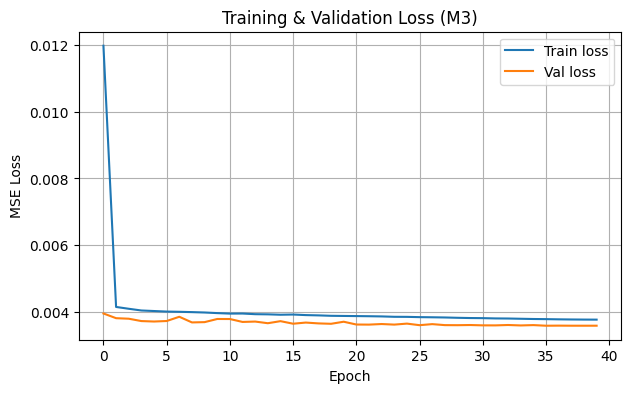

In [60]:
plt.figure(figsize=(7,4))
plt.plot(train_losses, label="Train loss")
plt.plot(val_losses, label="Val loss")
plt.title("Training & Validation Loss (M3)")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid(True)
plt.legend()
plt.show()

explication

### Evaluation final

In [61]:
# ============================================================
# Final Evaluation (val & test) + Save metrics
# ============================================================

# Recharger le meilleur modèle
if best_state is not None:
    model.load_state_dict(best_state["model_state"])
else:
    print("⚠️ Avertissement : aucun best_state, on garde le dernier modèle.")

def evaluate(dataloader, set_name="set"):
    model.eval()
    preds_std = []
    trues_std = []
    with torch.no_grad():
        for xb, yb in dataloader:
            xb = xb.to(device)
            pred = model(xb)
            preds_std.append(pred.cpu().numpy())
            trues_std.append(yb.numpy())
    preds_std = np.vstack(preds_std)
    trues_std = np.vstack(trues_std)

    # Retour à l'échelle °C
    preds = y_scaler.inverse_transform(preds_std)
    trues = y_scaler.inverse_transform(trues_std)

    mse = mean_squared_error(trues, preds)
    mae = mean_absolute_error(trues, preds)
    rmse = np.sqrt(mse)
    r2 = r2_score(trues, preds)

    print(f"\n=== Metrics {set_name.upper()} ===")
    print(f"MSE  = {mse:.4f}")
    print(f"RMSE = {rmse:.4f}")
    print(f"MAE  = {mae:.4f}")
    print(f"R²   = {r2:.4f}")

    return {
        "mse": float(mse),
        "rmse": float(rmse),
        "mae": float(mae),
        "r2": float(r2),
    }, preds, trues

val_metrics, _, _ = evaluate(val_dl, "validation")
test_metrics, pred_test, true_test = evaluate(test_dl, "test")

# metrics.json : meilleure MSE de validation
metrics_path = OUTPUT_DIR / "metrics.json"
with open(metrics_path, "w") as f:
    json.dump({"best_val_mse": val_metrics["mse"]}, f, indent=4)
print("Sauvegarde :", metrics_path)

# eval.json : métriques complètes val & test
eval_path = OUTPUT_DIR / "eval.json"
with open(eval_path, "w") as f:
    json.dump({"val": val_metrics, "test": test_metrics}, f, indent=4)
print("Sauvegarde :", eval_path)



=== Metrics VALIDATION ===
MSE  = 0.2643
RMSE = 0.5141
MAE  = 0.1755
R²   = 0.9960

=== Metrics TEST ===
MSE  = 0.2905
RMSE = 0.5389
MAE  = 0.1786
R²   = 0.9959
Sauvegarde : /content/dl_project/starters/ts-project-starter/ts-project/outputs/metrics.json
Sauvegarde : /content/dl_project/starters/ts-project-starter/ts-project/outputs/eval.json


### Predicted vs Ground Truth

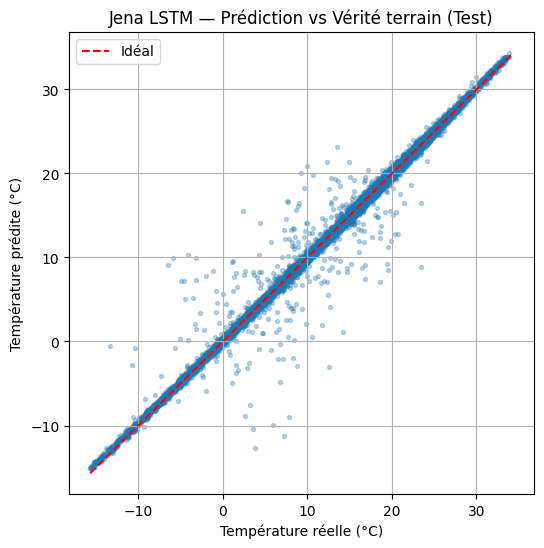

In [62]:
# ============================================================
# Plot Predicted vs Ground Truth (test set)
# ============================================================

plt.figure(figsize=(6, 6))
plt.scatter(true_test, pred_test, alpha=0.3, s=8)
min_v = min(true_test.min(), pred_test.min())
max_v = max(true_test.max(), pred_test.max())
plt.plot([min_v, max_v], [min_v, max_v], "r--", label="Idéal")
plt.xlabel("Température réelle (°C)")
plt.ylabel("Température prédite (°C)")
plt.title("Jena LSTM — Prédiction vs Vérité terrain (Test)")
plt.legend()
plt.grid(True)
plt.show()


### Tableau Residuals

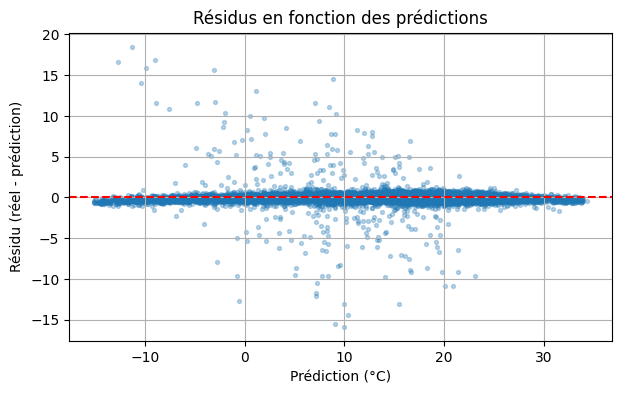

In [63]:
residuals = true_test - pred_test

plt.figure(figsize=(7, 4))
plt.scatter(pred_test, residuals, alpha=0.3, s=8)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Prédiction (°C)")
plt.ylabel("Résidu (réel - prédiction)")
plt.title("Résidus en fonction des prédictions")
plt.grid(True)
plt.show()

### Historigramme residuals

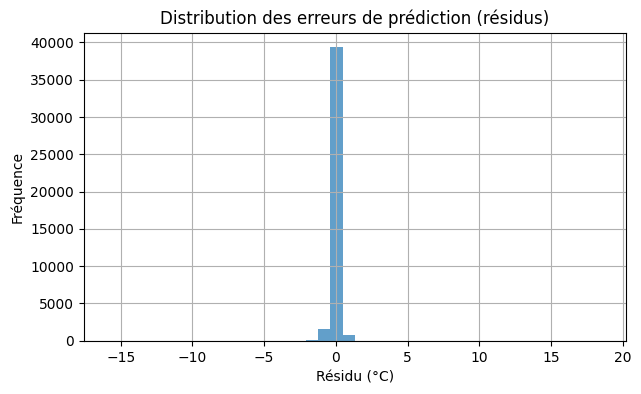

In [64]:
plt.figure(figsize=(7, 4))
plt.hist(residuals, bins=40, alpha=0.7)
plt.xlabel("Résidu (°C)")
plt.ylabel("Fréquence")
plt.title("Distribution des erreurs de prédiction (résidus)")
plt.grid(True)
plt.show()

### ANALYSE

[A FAIRE]

# M4 — Ablation Studies & Analysis

L’objectif de cette section est de mieux comprendre l’impact de certains
hyperparamètres clés sur les performances du modèle.

Conformément aux exigences du projet, nous réalisons **au moins deux ablations** :

---
1. Ablation 1 — Impact du Learning Rate

Le learning rate influence fortement :
- la vitesse de convergence,
- la stabilité de l’entraînement,
- la qualité du minimum trouvé.

Nous testerons :
- lr = 1e-4
- lr = 1e-3  (valeur YAML)
- lr = 1e-2

---

2. Ablation 2 — Taille du LSTM (hidden_dim)

La profondeur et largeur du réseau influencent la capacité du modèle à apprendre
des relations non linéaires.

Nous testerons trois architectures :
- H1 = 64   → plus petit modèle
- H2 = 128 → modèle du YAML (baseline)
- H3 = 256 → modèle plus large

---

3. Évaluation de chaque expérience
Nous mesurerons :
- MSE
- MAE
- RMSE
- R²

Puis nous enregistrerons les résultats dans un **DataFrame comparatif**.

Enfin, nous analyserons visuellement :
- le graphe Predicted vs Ground Truth,
- les résiduels,
- l’évolution de la dispersion des erreurs.

### Modèle un peu plus rapide

In [65]:
# ============================================================
#  Utility Training Function for Ablation Experiments
# ============================================================

def run_experiment(lr, hidden_dim, epochs=8):
    """
    Entraîne un LSTM avec lr et hidden_dim donnés.
    Retourne dict(MSE, MAE, RMSE, R2).
    """
    # 1) Nouveau modèle
    model_exp = LSTMRegressor(
        input_dim=len(feature_cols),
        hidden_dim=hidden_dim,
        num_layers=model_cfg["num_layers"],
        bidirectional=model_cfg["bidirectional"],
        dropout=model_cfg["dropout"],
    ).to(device)

    # 2) Nouvel optimizer
    optimizer_exp = torch.optim.AdamW(model_exp.parameters(), lr=lr)

    loss_fn = nn.MSELoss()

    # 3) Entraînement court
    for epoch in range(epochs):
        model_exp.train()
        for xb, yb in train_dl:
            xb, yb = xb.to(device), yb.to(device)
            preds = model_exp(xb)
            loss = loss_fn(preds, yb)

            optimizer_exp.zero_grad()
            loss.backward()
            optimizer_exp.step()

    # 4) Évaluation sur validation
    model_exp.eval()
    preds_list = []
    trues_list = []
    with torch.no_grad():
        for xb, yb in val_dl:
            xb = xb.to(device)
            pred = model_exp(xb)
            preds_list.append(pred.cpu().numpy())
            trues_list.append(yb.numpy())

    preds_std = np.vstack(preds_list)
    trues_std = np.vstack(trues_list)

    # inverse_transform (°C)
    preds = y_scaler.inverse_transform(preds_std)
    trues = y_scaler.inverse_transform(trues_std)

    mse = mean_squared_error(trues, preds)
    mae = mean_absolute_error(trues, preds)
    rmse = math.sqrt(mse)
    r2 = r2_score(trues, preds)

    return {
        "lr": lr,
        "hidden_dim": hidden_dim,
        "MSE": mse,
        "MAE": mae,
        "RMSE": rmse,
        "R²": r2
    }

### 1. Ablation 1 :  Learning Rate

In [66]:
# ============================================================
#  Ablation 1: Learning Rate
# ============================================================

learning_rates = [1e-4, 1e-3, 1e-2]
results = []

print("=== Ablation 1 : Learning Rate ===")
for lr in learning_rates:
    res = run_experiment(lr=lr, hidden_dim=128)   # hidden_dim = baseline
    results.append(res)
    print(res)

df_ablation = pd.DataFrame(results)
df_ablation


=== Ablation 1 : Learning Rate ===
{'lr': 0.0001, 'hidden_dim': 128, 'MSE': 0.2726597785949707, 'MAE': 0.1766199767589569, 'RMSE': 0.5221683431566593, 'R²': 0.9959002137184143}
{'lr': 0.001, 'hidden_dim': 128, 'MSE': 0.26895228028297424, 'MAE': 0.1814284473657608, 'RMSE': 0.5186060935652167, 'R²': 0.9959559440612793}
{'lr': 0.01, 'hidden_dim': 128, 'MSE': 0.3195439875125885, 'MAE': 0.2794567346572876, 'RMSE': 0.5652822193494047, 'R²': 0.995195209980011}


,lr,hidden_dim,MSE,MAE,RMSE,R²
0,0.0001,128,0.272660,0.176620,0.522168,0.995900
1,0.0010,128,0.268952,0.181428,0.518606,0.995956
2,0.0100,128,0.319544,0.279457,0.565282,0.995195


### 2. Ablation 2 : Taille du MLP

In [67]:
# ============================================================
#  Ablation 2: Model Size
# ============================================================

hidden_dims     = [64, 128, 256]

results = []

print("\n=== Ablation 2 : hidden_dim ===")
for hd in hidden_dims:
    res = run_experiment(lr=1e-3, hidden_dim=hd)  # lr = baseline
    results.append(res)
    print(res)

# DataFrame récapitulatif
df_ablation_h = pd.DataFrame(results)
df_ablation_h



=== Ablation 2 : hidden_dim ===
{'lr': 0.001, 'hidden_dim': 64, 'MSE': 0.268879771232605, 'MAE': 0.17533504962921143, 'RMSE': 0.518536181218442, 'R²': 0.9959570169448853}
{'lr': 0.001, 'hidden_dim': 128, 'MSE': 0.2699975073337555, 'MAE': 0.17799720168113708, 'RMSE': 0.5196128436959151, 'R²': 0.9959402084350586}
{'lr': 0.001, 'hidden_dim': 256, 'MSE': 0.27268847823143005, 'MAE': 0.19866184890270233, 'RMSE': 0.5221958236441863, 'R²': 0.9958997368812561}


,lr,hidden_dim,MSE,MAE,RMSE,R²
0,0.001,64,0.268880,0.175335,0.518536,0.995957
1,0.001,128,0.269998,0.177997,0.519613,0.995940
2,0.001,256,0.272688,0.198662,0.522196,0.995900


### Tableau Comparatif

In [68]:
# ============================================================
#  Combined Comparison Table
# ============================================================

df_ablation_t = pd.concat([df_ablation, df_ablation_h], ignore_index=True)
df_ablation_t


,lr,hidden_dim,MSE,MAE,RMSE,R²
0,0.0001,128,0.272660,0.176620,0.522168,0.995900
1,0.0010,128,0.268952,0.181428,0.518606,0.995956
2,0.0100,128,0.319544,0.279457,0.565282,0.995195
3,0.0010,64,0.268880,0.175335,0.518536,0.995957
4,0.0010,128,0.269998,0.177997,0.519613,0.995940
5,0.0010,256,0.272688,0.198662,0.522196,0.995900


### ANALYSE

[A FAIRE]

# M5 — Reporting & Final Delivery

---